### The MLDA sampler
This notebook is a good starting point to understand the basic usage of the Multi-Level Delayed Acceptance MCMC algorithm (MLDA) proposed in [1], as implemented within PyMC3.

It uses a simple linear regression model (and a toy coarse model counterpart) to show the basic workflow when using MLDA. The model is similar to the one used in https://docs.pymc.io/notebooks/GLM-linear.html.

The MLDA sampler is designed to deal with computationally intensive problems where we have access not only to the desired (fine) posterior distribution but also to a set of approximate (coarse) posteriors of decreasing accuracy and decreasing computational cost (we need at least one of those). Its main idea is that coarser chains' samples are used as proposals for the finer chains. A coarse chain runs for a fixed number of iterations and the last sample is used as a proposal for the finer chain. This has been shown to improve the effective sample size of the finest chain and this allows us to reduce the number of expensive fine-chain likelihood evaluations. 

The PyMC3 implementation supports:
- Any number of levels
- Two types of bottom-level samplers (Metropolis, DEMetropolisZ)
- Various tuning parameters for the bottom-level samplers
- Separate subsampling rates for each level
- A choice between blocked and compound sampling for bottom-level Metropolis. 
- An adaptive error model to correct bias between coarse and fine models 
- A variance reduction technique that utilizes samples from all chains to reduce the variance of an estimated quantity of interest.

For more details about the MLDA sampler and the way it should be used and parameterised, the user can refer to the docstrings in the code and to the other example notebooks which deal with more complex problem settings and more advanced MLDA features.

Please note that the MLDA sampler is new in PyMC3. The user should be extra critical about the results and report any problems as issues in the PyMC3's github repository.

[1] Dodwell, Tim & Ketelsen, Chris & Scheichl, Robert & Teckentrup, Aretha. (2019). Multilevel Markov Chain Monte Carlo. SIAM Review. 61. 509-545. https://doi.org/10.1137/19M126966X

### Work flow

MLDA is used in a similar way as most step method in PyMC3. It has the special requirement that the user need to provide at least one coarse model to allow it to work.

The basic flow to use MLDA consists of four steps, which we demonstrate here using a simple linear regression model with a toy coarse model counterpart.


##### Step 1: Generate some data

Here, we generate a vector `x` of 200 points equally spaced between 0.0 and 1.0. Then we project those onto a straight line with intercept 1.0 and slope 2.0, adding some random noise, resulting in a vector `y`. The goal is to infer the intercept and slope from `x` and `y`, i.e. a very simple linear regression problem.

In [1]:
# Import libraries
import time as time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
# Generate data
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

true_intercept = 1
true_slope = 2
sigma = 1

size = 200
x = np.linspace(0, 1, size)
y = true_intercept + true_slope * x + np.random.normal(0, sigma ** 2, size)

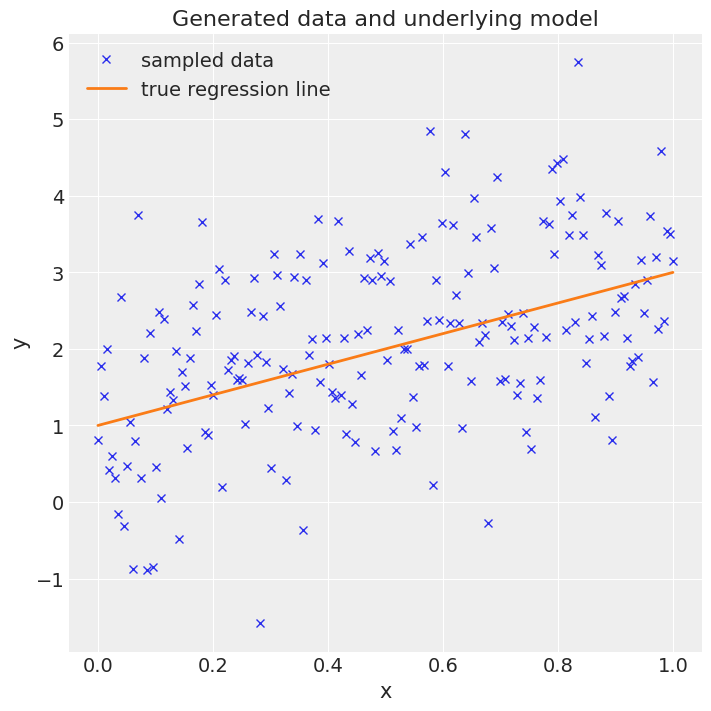

In [4]:
# Plot the data
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_intercept + true_slope * x, label="true regression line", lw=2.0)
plt.legend(loc=0);

##### Step 2: Define the fine model

In this step we use the PyMC3 model definition language to define the priors and the likelihood. We choose non-informative Normal priors for both intercept and slope and a Normal likelihood, where we feed in `x` and `y`.

In [5]:
# Constructing the fine model
with pm.Model() as fine_model:
    # Define priors
    intercept = pm.Normal("intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

##### Step 3: Define a coarse model
    
Here, we define a toy coarse model where coarseness is introduced by using fewer data in the likelihood compared to the fine model, i.e. we only use every 2nd data point from the original data set.

In [6]:
# Thinning the data set
x_coarse = x[::2]
y_coarse = y[::2]

In [7]:
# Constructing the coarse model
with pm.Model() as coarse_model:
    # Define priors
    intercept = pm.Normal("intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * x_coarse, sigma=sigma, observed=y_coarse)

##### Step 4: Draw MCMC samples from the posterior using MLDA 

We feed `coarse_model` to the MLDA instance and we also set `subsampling_rate` to 10. The subsampling rate is the number of samples drawn in the coarse chain to construct a proposal for the fine chain. In this case, MLDA draws 10 samples in the coarse chain and uses the last one as a proposal for the fine chain. This is accepted or rejected by the fine chain and then control goes back to the coarse chain which generates another 10 samples, etc. Note that `pm.MLDA` has many other tuning arguments which can be found in the documentation. 

Next, we use the universal `pm.sample` method, passing the MLDA instance to it. This runs MLDA and returns a `trace`, containing all MCMC samples and various by-products. Here, we also run standard Metropolis and DEMetropolisZ samplers for comparison, which return separate traces. We time the runs to compare later.

Finally, PyMC3 provides various functions to visualise the trace and print summary statistics (two of them are shown below).

In [8]:
with fine_model:
    # Initialise step methods
    step = pm.MLDA(coarse_models=[coarse_model], subsampling_rates=[10])
    step_2 = pm.Metropolis()
    step_3 = pm.DEMetropolisZ()

    # Sample using MLDA
    t_start = time.time()
    trace = pm.sample(draws=6000, chains=4, tune=2000, step=step, random_seed=RANDOM_SEED)
    runtime = time.time() - t_start

    # Sample using Metropolis
    t_start = time.time()
    trace_2 = pm.sample(draws=6000, chains=4, tune=2000, step=step_2, random_seed=RANDOM_SEED)
    runtime_2 = time.time() - t_start

    # Sample using DEMetropolisZ
    t_start = time.time()
    trace_3 = pm.sample(draws=6000, chains=4, tune=2000, step=step_3, random_seed=RANDOM_SEED)
    runtime_3 = time.time() - t_start

/home/mikkel/venv/pymc3_mlda_develop/lib/python3.6/site-packages/pymc3/step_methods/mlda.py:385: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (4 chains in 4 jobs)
MLDA: [slope, intercept]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 42 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [slope]
>Metropolis: [intercept]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 6 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [slope, intercept]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/mikkel/venv/pymc3_mlda_develop/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/mikkel/venv/pymc3_mlda_develop/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/mikkel/venv/pymc3_mlda_develop/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or c

array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>]], dtype=object)

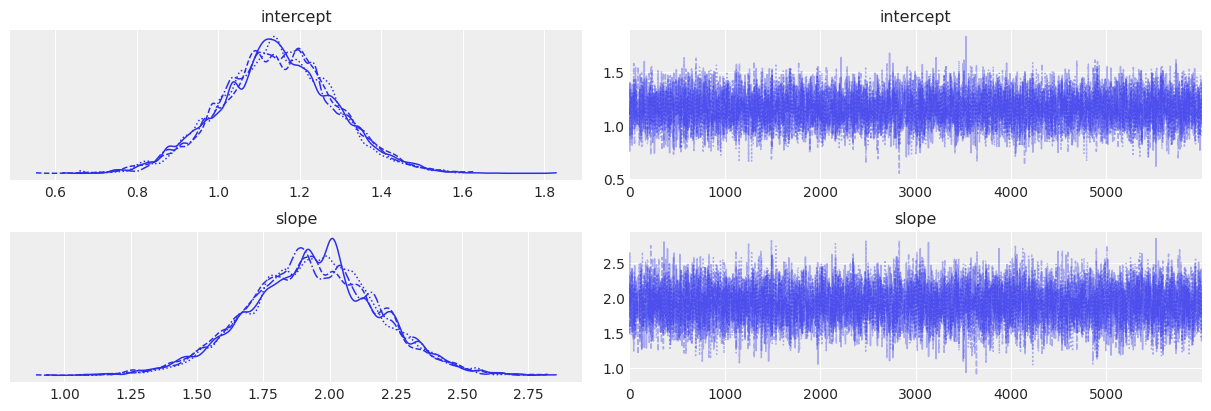

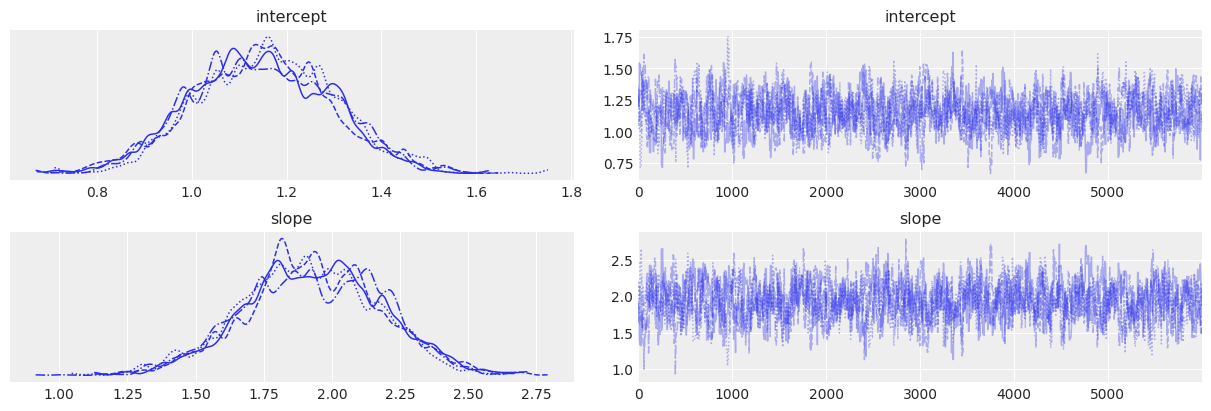

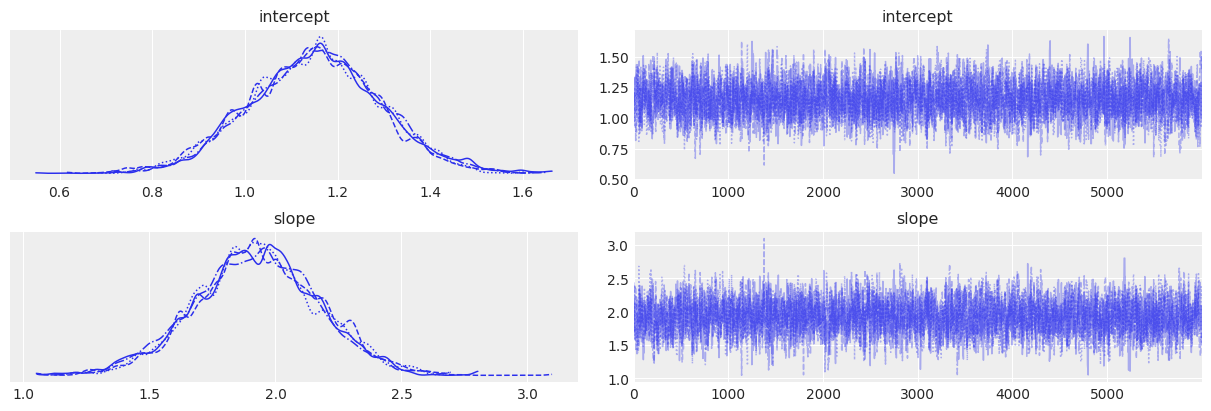

In [9]:
# Trace plots
pm.plots.traceplot(trace)
pm.plots.traceplot(trace_2)
pm.plots.traceplot(trace_3)

In [10]:
# Summary statistics for MLDA
pm.stats.summary(trace)

/home/mikkel/venv/pymc3_mlda_develop/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,1.146,0.140,0.876,1.406,0.002,0.001,7686.0,7686.0,7673.0,7048.0,1.0
slope,1.934,0.244,1.477,2.397,0.003,0.002,7755.0,7667.0,7733.0,7577.0,1.0


In [11]:
# Summary statistics for Metropolis
pm.stats.summary(trace_2)

/home/mikkel/venv/pymc3_mlda_develop/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,1.150,0.145,0.875,1.410,0.006,0.004,586.0,583.0,587.0,1143.0,1.0
slope,1.928,0.251,1.445,2.384,0.010,0.007,595.0,595.0,596.0,1237.0,1.0


In [12]:
# Summary statistics for DEMetropolisZ
pm.stats.summary(trace_3)

/home/mikkel/venv/pymc3_mlda_develop/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,1.150,0.141,0.886,1.415,0.003,0.002,3008.0,3008.0,3007.0,4414.0,1.0
slope,1.926,0.244,1.457,2.381,0.004,0.003,2954.0,2954.0,2956.0,4319.0,1.0


In [13]:
# Make sure samplers have converged
assert all(az.rhat(trace) < 1.03)
assert all(az.rhat(trace_2) < 1.03)
assert all(az.rhat(trace_3) < 1.03)

/home/mikkel/venv/pymc3_mlda_develop/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [14]:
# Display runtimes
print(f"Runtimes: MLDA: {runtime}, Metropolis: {runtime_2}, DEMetropolisZ: {runtime_3}")

Runtimes: MLDA: 42.62281012535095, Metropolis: 7.004178047180176, DEMetropolisZ: 5.836052179336548


##### Comments

**Performance:**

You can see from the summary statistics above that MLDA's ESS is ~13x higher than Metropolis and ~2.5x higher than DEMetropolisZ. The runtime of MLDA is ~3.5x larger than either Metropolis or DEMetropolisZ. Therefore in this toy example MLDA is almost an overkill (especially compared to DEMetropolisZ). For more complex problems, where the difference in computational cost between the coarse and fine models/likelihoods is orders of magnitude, MLDA is expected to outperform the other two samplers, as long as the coarse model is reasonably close to the fine one. This case is often enountered in inverse problems in engineering, ecology, imaging, etc where a forward model can be defined with varying coarseness in space and/or time (e.g. subsurface water flow, predator prey models, etc). For an example of this, please see the `MLDA_gravity_surveying.ipynb notebook` in the same folder.

**Subsampling rate:**

The MLDA sampler is based on the assumption that the coarse proposal samples (i.e. the samples proposed from the coarse chain to the fine one) are independent (or almost independent) from each other. In order to generate independent samples, it is necessary to run the coarse chain for an adequate number of iterations to get rid of autocorrelation. Therefore, the higher the autocorrelation in the coarse chain, the more iterations are needed and the larger the subsampling rate should be. 

Values larger than the minimum for beating autocorreletion can further improve the proposal (as the distribution is explored better and the proposal are imptoved), and thus ESS. But at the same time more steps cost more computationally. Users are encouraged to do test runs with different subsampling rates to understand which gives the best ESS/sec. 

Note that in cases where you have more than one coarse model/level, MLDA allows you to choose a different subsampling rate for each coarse level (as a list of integers when you instantiate the stepper).

In [15]:
# Show packages' and Python's versions
%load_ext watermark
%watermark -n -u -v -iv -w

numpy 1.19.2
arviz 0.10.0
pymc3 3.9.3
last updated: Thu Oct 15 2020 

CPython 3.6.9
IPython 7.16.1
watermark 2.0.2
